In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
# import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2023-07-26 22:57:31.028230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 22:57:48.953192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
import librosa
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from scipy import signal
import numpy as np
import librosa
# import librosa.display
import wave
import random as rn
import tensorflow as tf
from keras.utils import to_categorical
import seaborn as sns
%matplotlib inline

In [19]:
import librosa
# import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Function to extract Mel spectrogram features from audio file
# def get_feature(audio_file, n_mels=128, duration=3):
#     # Function to extract Mel spectrogram features from audio file
# def get_feature(audio_file, n_mels=128, duration=3):
#     y, sr = librosa.load(audio_file, duration=duration)
#     mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
#     return librosa.power_to_db(mel_spectrogram, ref=np.max), sr

In [21]:
# from tqdm import tqdm

# # Initialize empty lists
# features = []
# labels = []
# # female_features = []
# # female_labels = []

# # Use tqdm to track progress
# c = 0

# for curr_file in tqdm(fn, desc="Processing files", 
#                       unit="file"):
#     curr_feat, sr = get_feature(curr_file)
#     curr_meta = get_metadata(curr_file)
#     if curr_meta[1] == 'male':
#         features.append(curr_feat)
#         labels.append(curr_meta[0])
#     c = c + 1
#     if c == 10:
#         break
#     # else:
#     #     # female_features.append(curr_feat)
#     #     # female_labels.append(curr_meta[0])
#     #     continue
    
# # Define the list of possible values
# possible_values = list(set(male_labels))

# # Your list of strings to be encoded
# # input_strings = ['happy', 'sad', 'angry', 'calm']

# # Create a mapping from each value to its index
# value_to_index = {value: index for index, value in enumerate(possible_values)}

# # Map each string to its corresponding index
# encoded_indices = [value_to_index[string] for string in male_labels]

# # Perform one-hot encoding
# one_hot_matrix = tf.one_hot(indices=encoded_indices, depth=len(possible_values))

# # Convert the TensorFlow tensor to a NumPy array (optional)
# labels_en = one_hot_matrix.numpy()

Processing files:   1%|▏                                | 9/1440 [00:00<00:32, 44.17file/s]


In [9]:
# len(male_features[0])

128

In [22]:
features = np.array(male_features)
labels_en = np.array(male_labels_en)

In [25]:
# Set the number of Mel frequency bands
# n_mels = 128  # Modify this as needed

# # Assuming the output size is (128, duration_in_seconds*sr), pad or resize to a fixed size
# duration_in_seconds = 3  # Modify this as needed
# max_duration_frames = duration_in_seconds * sr
# padded_features = np.zeros((len(features), n_mels, max_duration_frames))
# for i in range(len(features)):
#     padded_features[i, :, :features[i].shape[1]] = features[i][:, :max_duration_frames]

# features = padded_features

# target_labels = np.array(labels_en)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features, target_labels, test_size=0.2, random_state=42)


In [26]:
# Reshape the data to fit the input requirements of the CNN
# X_train = X_train[..., np.newaxis]
# X_test = X_test[..., np.newaxis]


In [2]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [4]:
fn = []
for dirname, _, filenames in os.walk('/mount/Project/Project Files/Data/Audio/Audio Speech Sentiment/'):
    for filename in filenames:
        fn.append(os.path.join(dirname, filename))     

In [2]:
import matplotlib.pyplot as plt 
# import librosa.display


def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    # plt.show()
    


def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    # plt.colorbar()

In [15]:
fn[0]

'/mount/Project/Project Files/Data/Audio/Audio Speech Sentiment/Actor_01/03-01-01-01-01-01-01.wav'

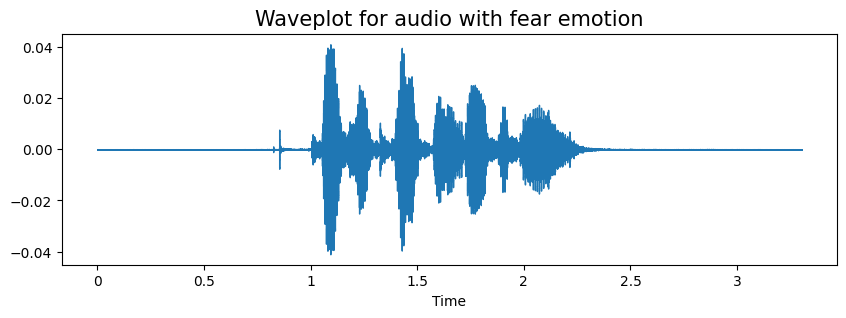

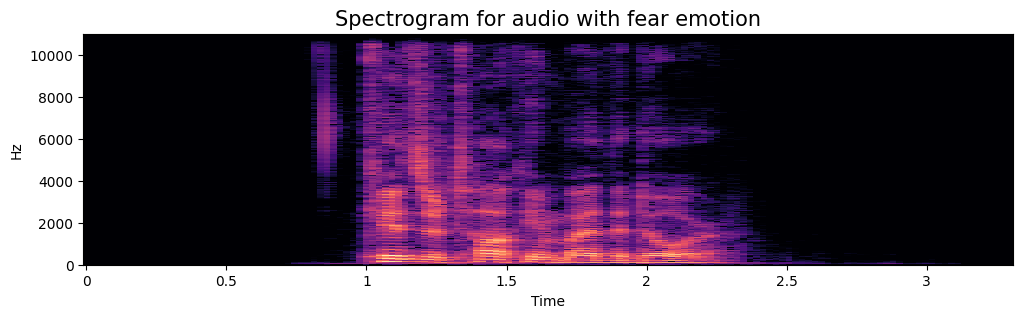

In [5]:
emotion='fear'
path = fn[0]  # np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

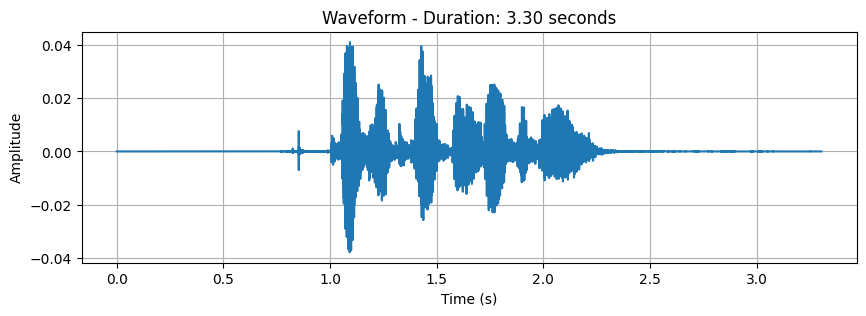

In [12]:
def plot_waveform(data, sampling_rate):
    # Calculate the duration of the audio in seconds
    duration = len(data) / sampling_rate

    # Create a time array for the x-axis (time in seconds)
    time = np.linspace(0, duration, num=len(data))

    # Plot the waveform
    plt.figure(figsize=(10, 3))
    plt.plot(time, data)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Waveform - Duration: {duration:.2f} seconds")
    plt.grid(True)
    plt.show()
    
plot_waveform(data, sampling_rate)

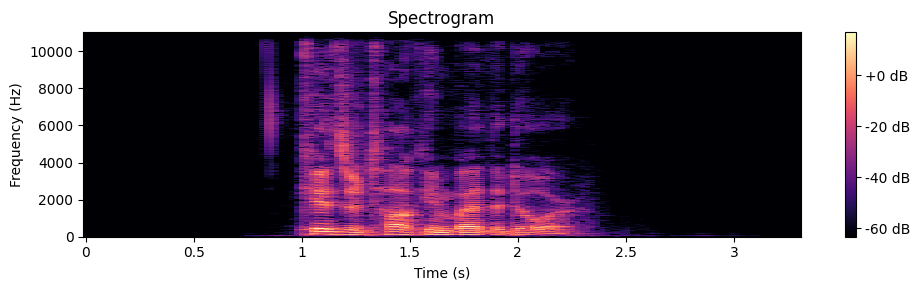

In [11]:
def plot_spectrogram(data, sampling_rate):
    # Calculate the spectrogram using librosa's stft function
    spectrogram = librosa.stft(data)

    # Convert the power spectrogram to dB scale
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram))

    # Plot the spectrogram
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(spectrogram_db, sr=sampling_rate, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')  # Add a colorbar representing dB scale
    plt.title("Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

plot_spectrogram(data, sampling_rate)

In [13]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = fn[1]
data, sample_rate = librosa.load(path)

<Figure size 1400x400 with 0 Axes>

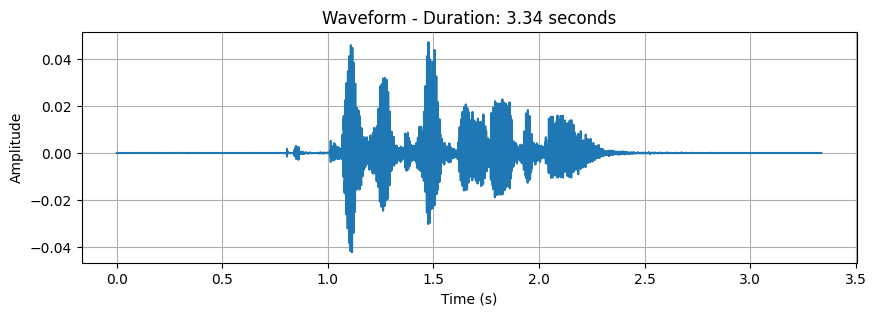

In [15]:
plt.figure(figsize=(14,4))
plot_waveform(data, sample_rate)
Audio(path)

<Figure size 1400x400 with 0 Axes>

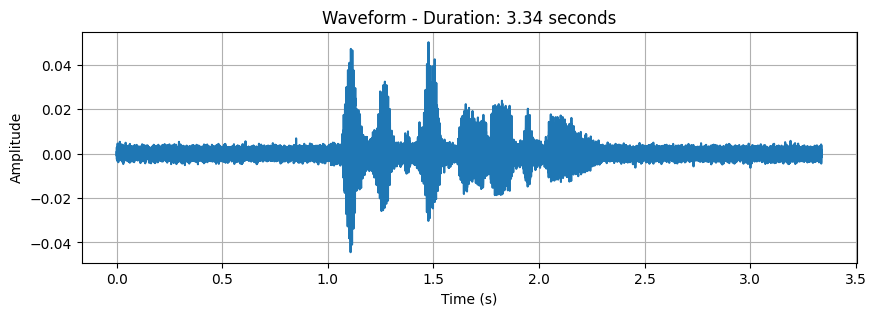

In [16]:
x = noise(data)
plt.figure(figsize=(14,4))
plot_waveform(x, sample_rate)
Audio(x, rate=sample_rate)

<Figure size 1400x400 with 0 Axes>

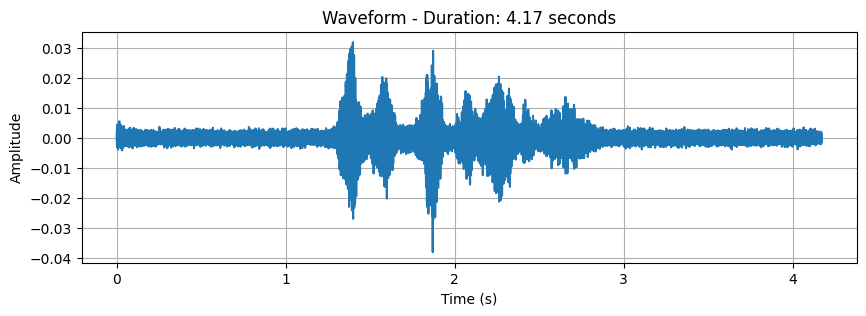

In [23]:
x = librosa.effects.time_stretch(x, rate=0.8) # stretch(data, rate=0.8)
plt.figure(figsize=(14,4))
plot_waveform(x, sample_rate)
Audio(x, rate=sample_rate)

<Figure size 1400x400 with 0 Axes>

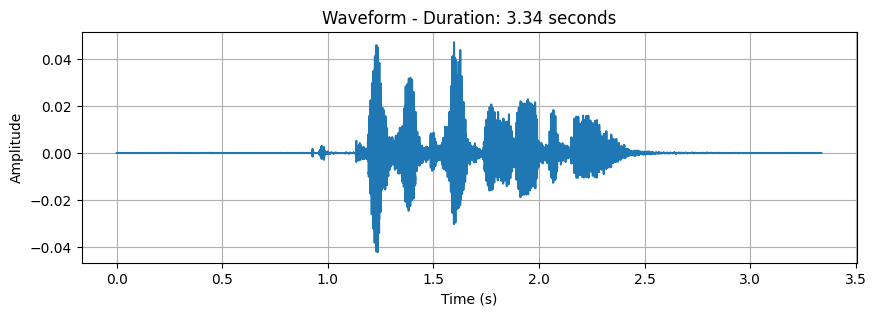

In [25]:
x = shift(data)
plt.figure(figsize=(14,4))
plot_waveform(x, sample_rate)
Audio(x, rate=sample_rate)

<Figure size 1400x400 with 0 Axes>

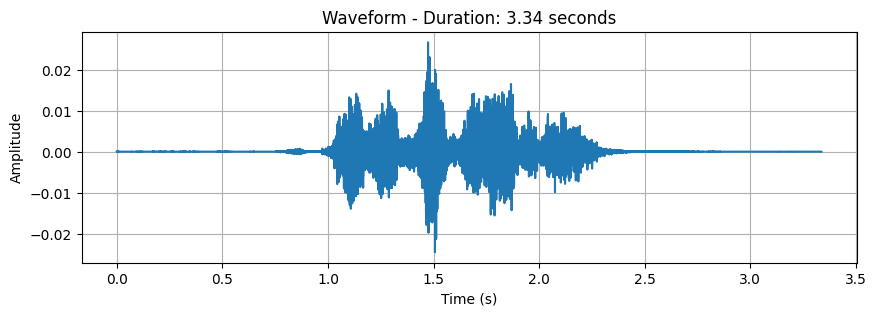

In [32]:
x = librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=0.7, 
                                # pitch_factor=0.7
                               )
plt.figure(figsize=(14,4))
plot_waveform(x, sample_rate)
Audio(x, rate=sample_rate)

In [37]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = librosa.effects.time_stretch(data, rate=0.8)
    # data_stretch_pitch = pitch(new_data, sample_rate)
    data_stretch_pitch = librosa.effects.pitch_shift(y=new_data, 
                                                     sr=sampling_rate, 
                                                     n_steps=0.7, 
                                # pitch_factor=0.7
                               )
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [39]:
len(get_features(fn[0]))

3

In [41]:
def get_metadata(file_name):
    if file_name[-len('03-01-06-02-02-01-07.wav'):][6:8] == '01':
        emo = 'neutral'
    elif file_name[-len('03-01-06-02-02-01-07.wav'):][6:8] == '02':
        emo = 'calm'
    elif file_name[-len('03-01-06-02-02-01-07.wav'):][6:8] == '03':
        emo = 'happy'
    elif file_name[-len('03-01-06-02-02-01-07.wav'):][6:8] == '04':
        emo = 'sad'
    elif file_name[-len('03-01-06-02-02-01-07.wav'):][6:8] == '05':
        emo = 'angry'
    elif file_name[-len('03-01-06-02-02-01-07.wav'):][6:8] == '06':
        emo = 'fearful'
    elif file_name[-len('03-01-06-02-02-01-07.wav'):][6:8] == '07':
        emo = 'disgust'
    elif file_name[-len('03-01-06-02-02-01-07.wav'):][6:8] == '08':
        emo = 'surprised'
        
    if int(file_name[-len('03-01-06-02-02-01-07.wav'):][18:20]) % 2 == 0:  # Gender
        gen = 'female'
    else:
        gen = 'male'
        # 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 
        # 05 = angry, 06 = fearful, 07 = disgust, 
        # 08 = surprised
    return emo, gen


In [86]:
# Starts from here - Kaggle 1

from tqdm import tqdm

# Initialize empty lists
features = []
labels = []
# female_features = []
# female_labels = []

# Use tqdm to track progress
c = 0

for curr_file in tqdm(fn, desc="Processing files", 
                      unit="file"):
    curr_meta = get_metadata(curr_file)
    curr_feat = get_features(curr_file)
    for ele in curr_feat:
        features.append(ele)
        labels.append(curr_meta[0])
        
    
    # c = c + 1
    # if c == 10:
    #     break

Processing files: 100%|██████████████████████████████| 1440/1440 [11:38<00:00,  2.06file/s]


In [44]:
len(labels)

30

In [87]:
Features = pd.DataFrame(features)
Features['labels'] = labels
# Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750032,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,4.310902e-06,3.291511e-06,2.148075e-06,2.279739e-06,5.116492e-06,8.190280e-06,0.000007,0.000005,4.245835e-07,neutral
1,0.316614,0.772069,0.821098,0.807381,0.814810,0.822342,0.742977,0.671272,0.710102,0.754568,...,5.785021e-05,5.457892e-05,5.485509e-05,5.625529e-05,6.157389e-05,6.435907e-05,0.000059,0.000059,5.414872e-05,neutral
2,0.188198,0.622088,0.699109,0.753246,0.721174,0.701756,0.682371,0.662858,0.686523,0.734027,...,8.577024e-07,9.576477e-07,7.733600e-07,5.233055e-07,3.593574e-07,9.267885e-07,0.000002,0.000001,7.754770e-08,neutral
3,0.293566,0.673896,0.722096,0.723508,0.682302,0.680533,0.675352,0.628977,0.679179,0.707283,...,6.984505e-06,7.034950e-06,6.654923e-06,6.979548e-06,1.214236e-05,9.640183e-06,0.000011,0.000006,4.254084e-07,neutral
4,0.317835,0.764785,0.809218,0.816959,0.779888,0.788713,0.759525,0.652702,0.690202,0.736295,...,8.622323e-05,8.754569e-05,8.690709e-05,8.512386e-05,8.770482e-05,8.342012e-05,0.000090,0.000085,7.766747e-05,neutral


In [88]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [89]:
# As this is a multiclass classification problem onehotencoding our Y.
# encoder = OneHotEncoder()
# Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

import tensorflow as tf

Y = Features['labels'].values

# Define the list of possible values
possible_values = list(set(Y))

# Your list of strings to be encoded
# input_strings = ['happy', 'sad', 'angry', 'calm']

# Create a mapping from each value to its index
value_to_index = {value: index for index, value in enumerate(possible_values)}

# Map each string to its corresponding index
encoded_indices = [value_to_index[string] for string in Y]

# Perform one-hot encoding
one_hot_matrix = tf.one_hot(indices=encoded_indices, depth=len(possible_values))

# Convert the TensorFlow tensor to a NumPy array (optional)
Y = one_hot_matrix.numpy()

In [90]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [91]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [92]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

In [93]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=y_train.shape[1], activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 81, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 41, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 21, 128)         

In [94]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 10s 114ms/step - loss: 1.9982 - accuracy: 0.1762 - val_loss: 1.9549 - val_accuracy: 0.2194 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 6s 109ms/step - loss: 1.9128 - accuracy: 0.2441 - val_loss: 1.8507 - val_accuracy: 0.3130 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 6s 112ms/step - loss: 1.8435 - accuracy: 0.2704 - val_loss: 1.8021 - val_accuracy: 0.2944 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 6s 119ms/step - loss: 1.7869 - accuracy: 0.3009 - val_loss: 1.7403 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 6s 124ms/step - loss: 1.7490 - accuracy: 0.3210 - val_loss: 1.6451 - val_accuracy: 0.3741 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 6s 120ms/step - loss: 1.6867 - accuracy: 0.3438 - val_loss: 1.6130 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 6s 127ms/step - l

In [54]:
x_train.shape

(22, 162, 1)

In [59]:
x_test.shape

(8, 162, 1)

In [55]:
y_train.shape

(22, 2)

In [56]:
y_test.shape

(8, 2)

In [57]:
y_test[0]

array([0., 1.])

In [58]:
y_train[0]

array([1., 0.])

In [61]:
y_train[0]

array([1., 0.])

In [71]:
Y[0]

array([0., 1.], dtype=float32)

In [95]:
labels[:5]

['neutral', 'neutral', 'neutral', 'neutral', 'neutral']

In [78]:
y_train.shape

(22, 2)

34/34 [==============================] - 1s 15ms/step - loss: 1.5027 - accuracy: 0.6481
Accuracy of our model on test data :  64.81481194496155 %


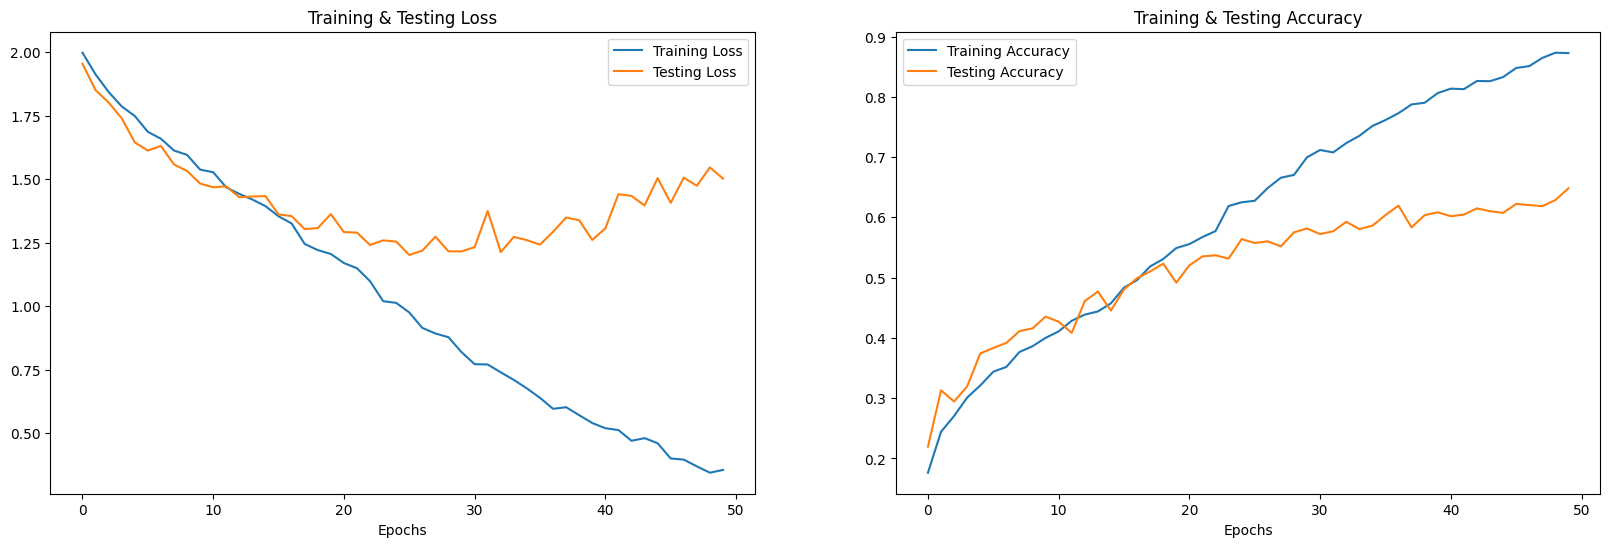

In [96]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [122]:
# predicting on test data.
pred_test = model.predict(x_test)
# y_pred = encoder.inverse_transform(pred_test)

# y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 1s 14ms/step


In [100]:
pred_test[0]

array([7.5859233e-04, 4.1266138e-04, 8.3827346e-12, 9.9882740e-01,
       8.6983437e-07, 5.4137342e-07, 5.0677120e-09, 1.6050275e-14],
      dtype=float32)

In [124]:
decoded_labels = [possible_values[np.argmax(row)] for row in Y]

pred_test_unen = [possible_values[np.argmax(row)] for row in pred_test]

print(pred_test_unen[:5])

['fearful', 'fearful', 'disgust', 'calm', 'angry']


In [107]:
len(pred_test)

1080

In [108]:
len(y_test)

1080

In [125]:
y_test_unen = [possible_values[np.argmax(row)] for row in y_test]
y_test_unen[:4]

['fearful', 'angry', 'disgust', 'calm']

In [126]:
y_test[0]

array([0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [128]:
y_test_unen[0]

'fearful'

In [129]:
pred_test[0]

array([7.5859233e-04, 4.1266138e-04, 8.3827346e-12, 9.9882740e-01,
       8.6983437e-07, 5.4137342e-07, 5.0677120e-09, 1.6050275e-14],
      dtype=float32)

In [130]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = pred_test_unen
df['Actual Labels'] = y_test_unen

df.head(10)

,Predicted Labels,Actual Labels
0,fearful,fearful
1,fearful,angry
2,disgust,disgust
3,calm,calm
4,angry,angry
5,surprised,surprised
6,fearful,fearful
7,happy,happy
8,fearful,fearful
9,sad,sad


In [131]:
y_pred[0]

array(['calm'], dtype=object)

In [135]:
pred_test[0]

array([7.5859233e-04, 4.1266138e-04, 8.3827346e-12, 9.9882740e-01,
       8.6983437e-07, 5.4137342e-07, 5.0677120e-09, 1.6050275e-14],
      dtype=float32)

{'angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised'}

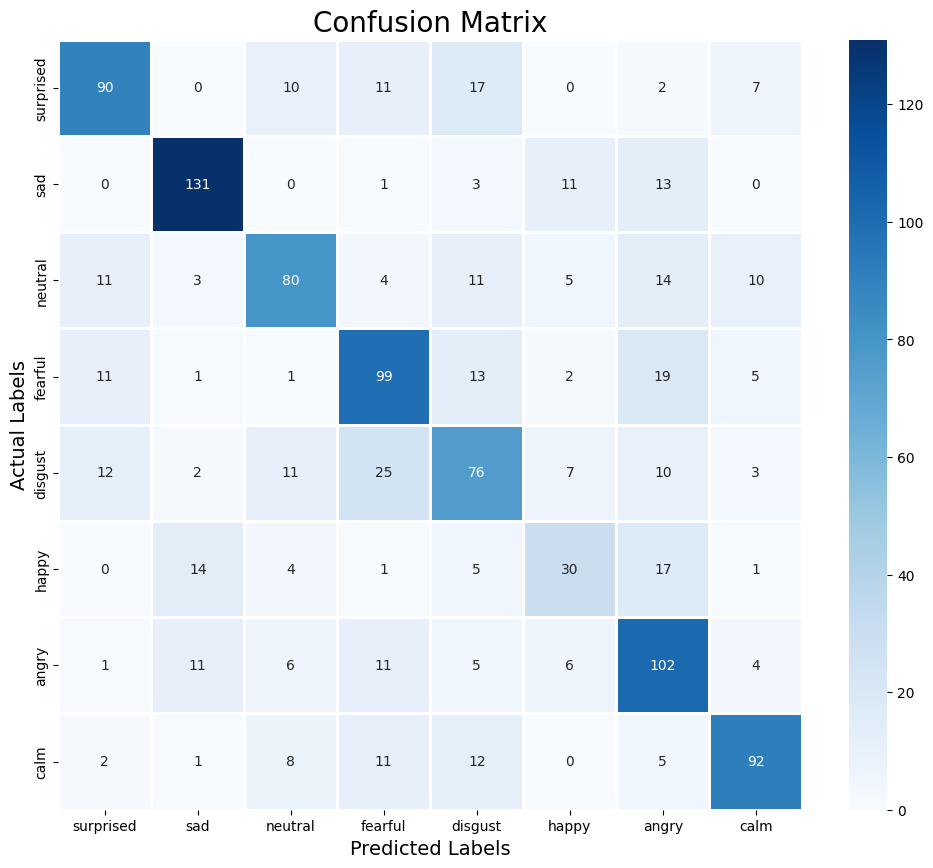

In [140]:
cm = confusion_matrix(y_test_unen, pred_test_unen)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in set(y_test_unen)] , columns = [i for i in set(y_test_unen)])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [137]:
print(classification_report(y_test_unen, pred_test_unen))


              precision    recall  f1-score   support

       angry       0.71      0.66      0.68       137
        calm       0.80      0.82      0.81       159
     disgust       0.67      0.58      0.62       138
     fearful       0.61      0.66      0.63       151
       happy       0.54      0.52      0.53       146
     neutral       0.49      0.42      0.45        72
         sad       0.56      0.70      0.62       146
   surprised       0.75      0.70      0.73       131

    accuracy                           0.65      1080
   macro avg       0.64      0.63      0.63      1080
weighted avg       0.65      0.65      0.65      1080

